<a href="https://colab.research.google.com/github/StrelecTanya/scRNA-Seq_project/blob/main/batch_a_lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Тема проекта:** Проверка различных программ для батч-коррекции на устойчивость к овер-коррекции



**Задача:** Искуственно создайте два батча, состоящие из (а) абсолютно разных и (б) частично перекрывающихся типов клеток и выполните батч-коррекцию как минимум тремя методами (Harmony, bbknn и третий по выбору) — охарактеризуйте стабильность каждого из рассмотренных вами методов к овер-коррекции батч-эффекта.

# Предобработка данных

In [ ]:
!pip install scanpy[leiden] harmonypy symphonypy bbknn

Загружаем датасет - scRNA-Seq легочной ткани, отобранные от 2х новорожденных девочек

In [ ]:
!wget https://datasets.cellxgene.cziscience.com/f7be56a5-55fc-4beb-8d5d-ffec21c11906.h5ad -O dataset.h5ad

Импортируем все необходимые библиотеки для обработки данных

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scanpy.external as sce

In [4]:
adata = sc.read_h5ad("dataset.h5ad")

В готовом файле, в adata.X уже предобработанные данные (судя по всему все шаги до шкалирования и отбора HVG). Для более адекватного результата буду работать с сырыми данными и сама их предобработаю.

In [5]:
# Создание нового объекта adata_raw с сырыми данными
adata_raw = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var)

Отбираем нужные типы клеток под задачу

In [7]:
#Смотрим какие типы клеток вообще есть в датасете
adata_raw.obs['cell_type'].value_counts()

,count
cell_type,
endothelial cell,1119
pericyte,908
myofibroblast cell,820
fibroblast of lung,814
smooth muscle cell,592
stromal cell,419
macrophage,349
T cell,190
pulmonary alveolar type 1 cell,131


In [10]:
#Отбираем так, чтобы в батчах были разные типы клеток
adata_1 = adata_raw[((adata_raw.obs['cell_type'] == 'pulmonary alveolar type 2 cell') | (adata_raw.obs['cell_type'] == 'endothelial cell')) & (adata_raw.obs['donor_id'] == 'D038')]
adata_2 = adata_raw[((adata_raw.obs['cell_type'] == 'myofibroblast cell') | (adata_raw.obs['cell_type'] == 'smooth muscle cell')) & (adata_raw.obs['donor_id'] == 'D051')]

# Объединение данных
adata = adata_1.concatenate(adata_2)

<ipython-input-10-5a40d3d810e9>:6: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_1.concatenate(adata_2)


In [11]:
adata.var["mt"] = adata.var.feature_name.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)

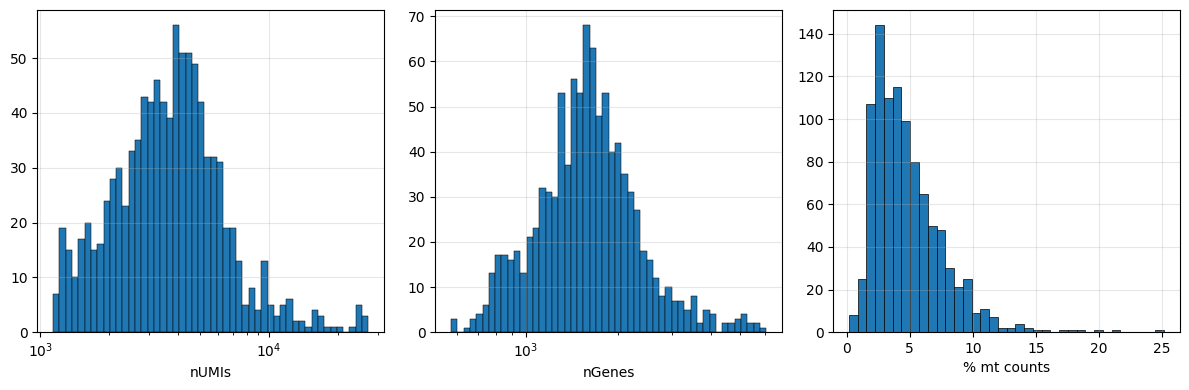

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.histplot(adata.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

In [13]:
adata = adata[adata.obs.n_genes_by_counts >= 700]

In [15]:
sc.pp.scrublet(adata, batch_key="donor_id")

In [16]:
adata = adata[adata.obs.doublet_score <= 0.2].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, batch_key="donor_id", n_top_genes=3000)

adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [20]:
#Теперь можем стандартизировать данные и сделать PCA
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=30)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<ipython-input-23-3e5adcd8bc11>:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_nocorr, resolution=0.05)


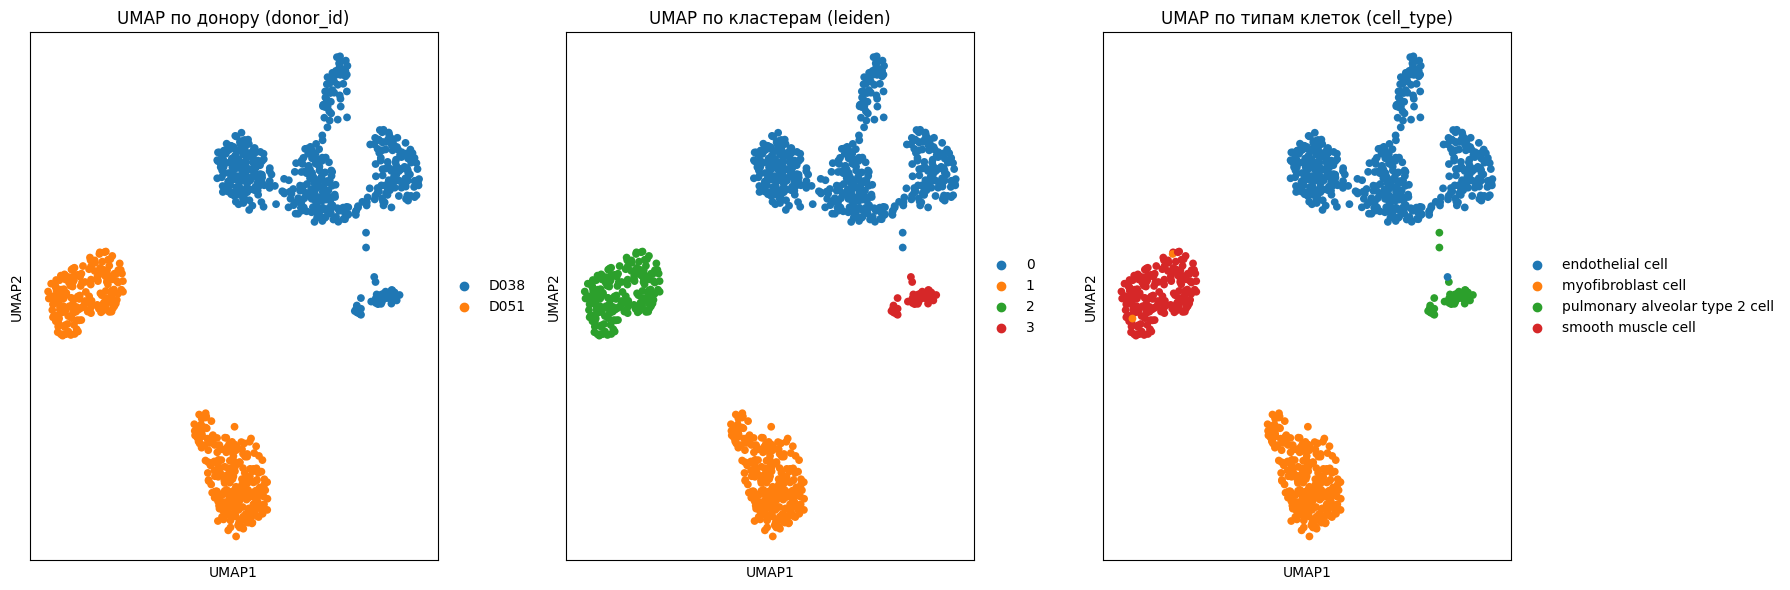

In [23]:
#Визуализация без батч-коррекции
# Создаем копию данных
adata_nocorr = adata.copy()

# Предобработка данных
sc.pp.neighbors(adata_nocorr)
sc.tl.umap(adata_nocorr)

# Создание подграфиков (subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Увеличиваем ширину фигуры

# Первый график - окрашивание по донору (donor_id)
sc.pl.umap(adata_nocorr, color='donor_id', ax=axes[0], show=False)
axes[0].set_title("UMAP по донору (donor_id)")

# Кластеризация и второй график - окрашивание по кластерам (leiden)
sc.tl.leiden(adata_nocorr, resolution=0.05)
sc.pl.umap(adata_nocorr, color="leiden", ax=axes[1], show=False)
axes[1].set_title("UMAP по кластерам (leiden)")

# Третий график - окрашивание по типам клеток (cell_type)
sc.pl.umap(adata_nocorr, color="cell_type", ax=axes[2], show=False)
axes[2].set_title("UMAP по типам клеток (cell_type)")

# Отображение графиков
plt.tight_layout()
plt.show()

<ipython-input-24-96fb93f862c9>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_nocorr.obs.groupby(["leiden", "donor_id"]).size().unstack().T


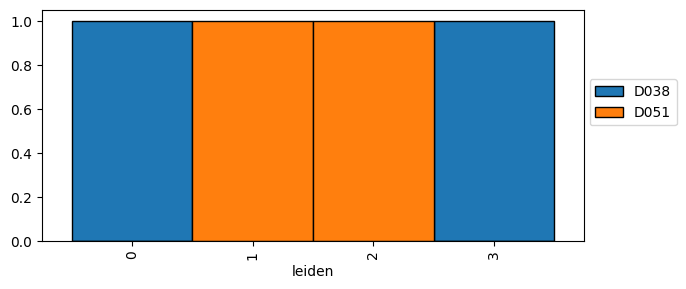

In [24]:
df = adata_nocorr.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

Мы видим четкие 4 кластера. В данной симуляции мы не должны видеть батч-эффект, так как клетки у доноров совершенно разные и по-хорошему корректоры не должны смешивать точки.

# bbKNN

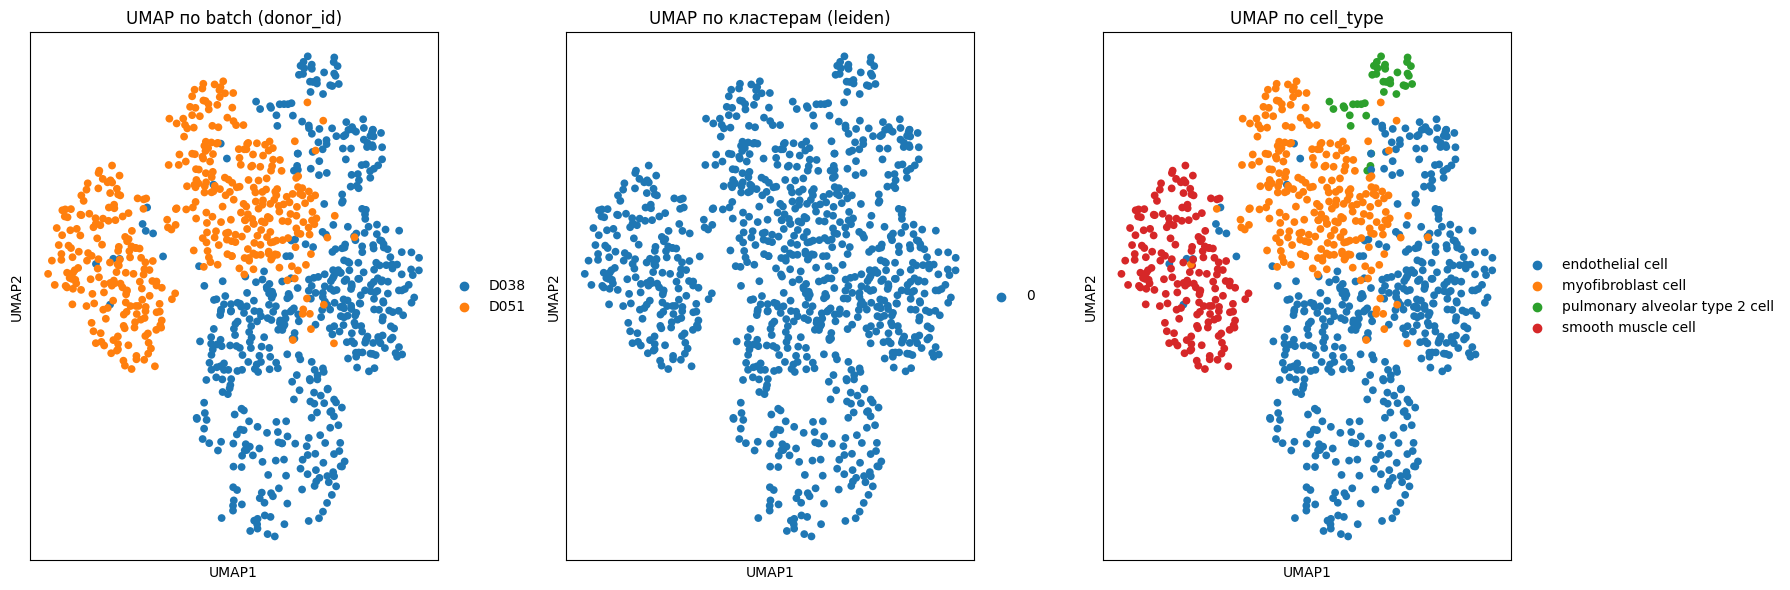

In [25]:
# Batch balanced kNN

adata_bbknn = adata.copy()

import bbknn
bbknn.bbknn(adata_bbknn, batch_key="donor_id", neighbors_within_batch=3) # 3 - дефолтное количество соседей
sc.tl.umap(adata_bbknn)

# Настраиваем подграфики (subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График с окрашиванием по batch
sc.pl.umap(adata_bbknn, color="donor_id", ax=axes[0], show=False)
axes[0].set_title("UMAP по batch (donor_id)")

# Кластеризация и второй график - окрашивание по кластерам (leiden)
sc.tl.leiden(adata_bbknn, resolution=0.05)
sc.pl.umap(adata_bbknn, color="leiden", ax=axes[1], show=False)
axes[1].set_title("UMAP по кластерам (leiden)")

# График с окрашиванием по cell_type
sc.pl.umap(adata_bbknn, color="cell_type", ax=axes[2], show=False)
axes[2].set_title("UMAP по cell_type")

# Отображаем графики
plt.tight_layout()
plt.show()

bbKNN насильно объединяет точки из разных батчей, но при настройке гиперпараметров (число соседей) можно добиться хорошего результата

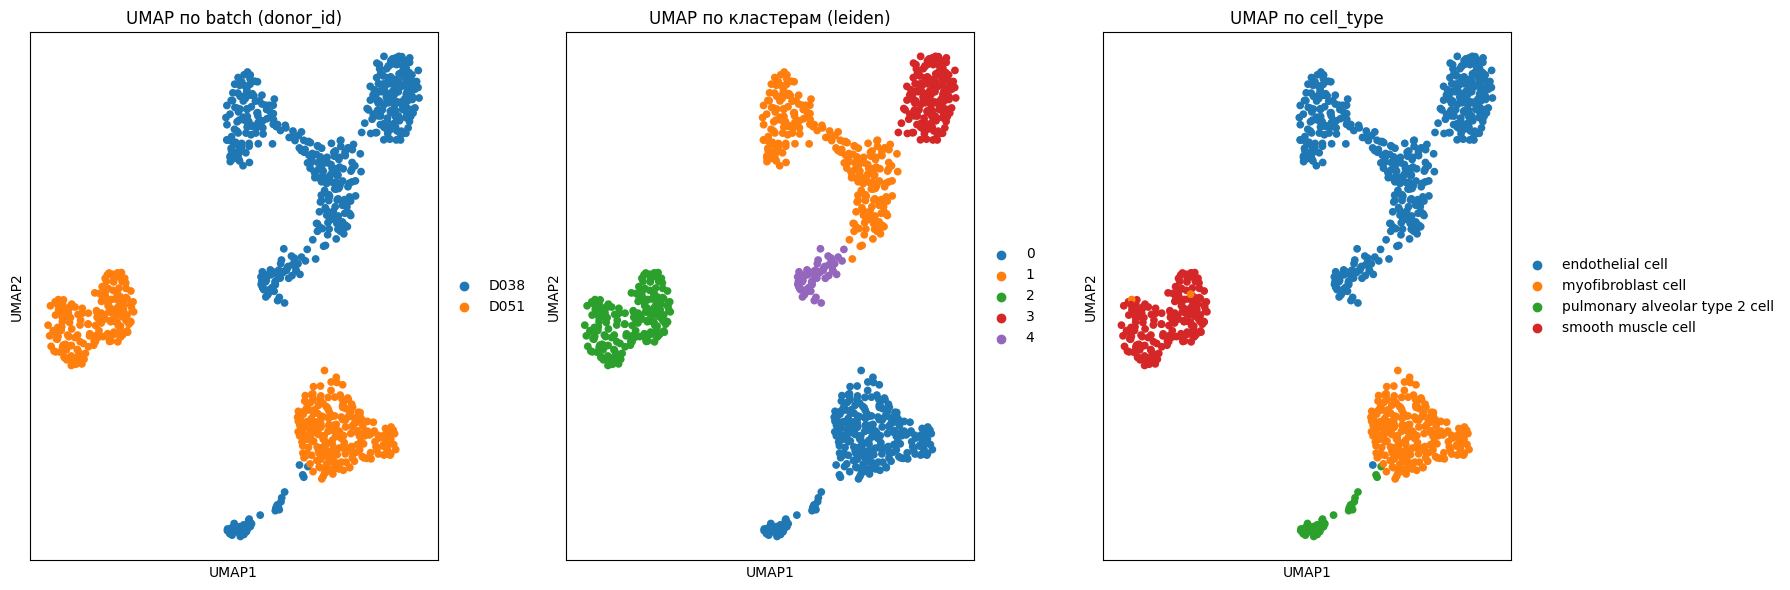

In [27]:
bbknn.bbknn(adata_bbknn, batch_key="donor_id", neighbors_within_batch=15)
sc.tl.umap(adata_bbknn)

# Настраиваем подграфики (subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График с окрашиванием по batch
sc.pl.umap(adata_bbknn, color="donor_id", ax=axes[0], show=False)
axes[0].set_title("UMAP по batch (donor_id)")

# Кластеризация и второй график - окрашивание по кластерам (leiden)
sc.tl.leiden(adata_bbknn, resolution=0.1)
sc.pl.umap(adata_bbknn, color="leiden", ax=axes[1], show=False)
axes[1].set_title("UMAP по кластерам (leiden)")

# График с окрашиванием по cell_type
sc.pl.umap(adata_bbknn, color="cell_type", ax=axes[2], show=False)
axes[2].set_title("UMAP по cell_type")

# Отображаем графики
plt.tight_layout()
plt.show()

<ipython-input-28-55f7a966c9c8>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_bbknn.obs.groupby(["leiden", "donor_id"]).size().unstack().T


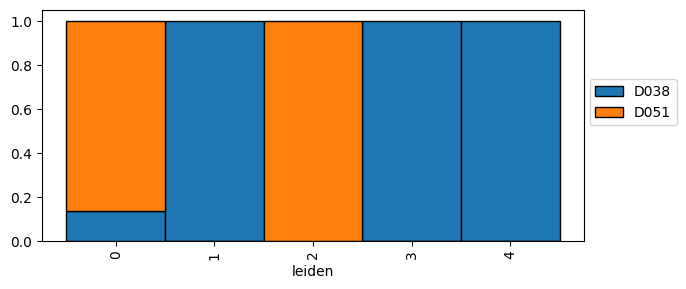

In [28]:
df = adata_bbknn.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

# Harmony

2024-12-19 21:07:48,192 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-12-19 21:07:48,426 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-12-19 21:07:48,439 - harmonypy - INFO - Iteration 1 of 30
INFO:harmonypy:Iteration 1 of 30
2024-12-19 21:07:48,630 - harmonypy - INFO - Iteration 2 of 30
INFO:harmonypy:Iteration 2 of 30
2024-12-19 21:07:48,843 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


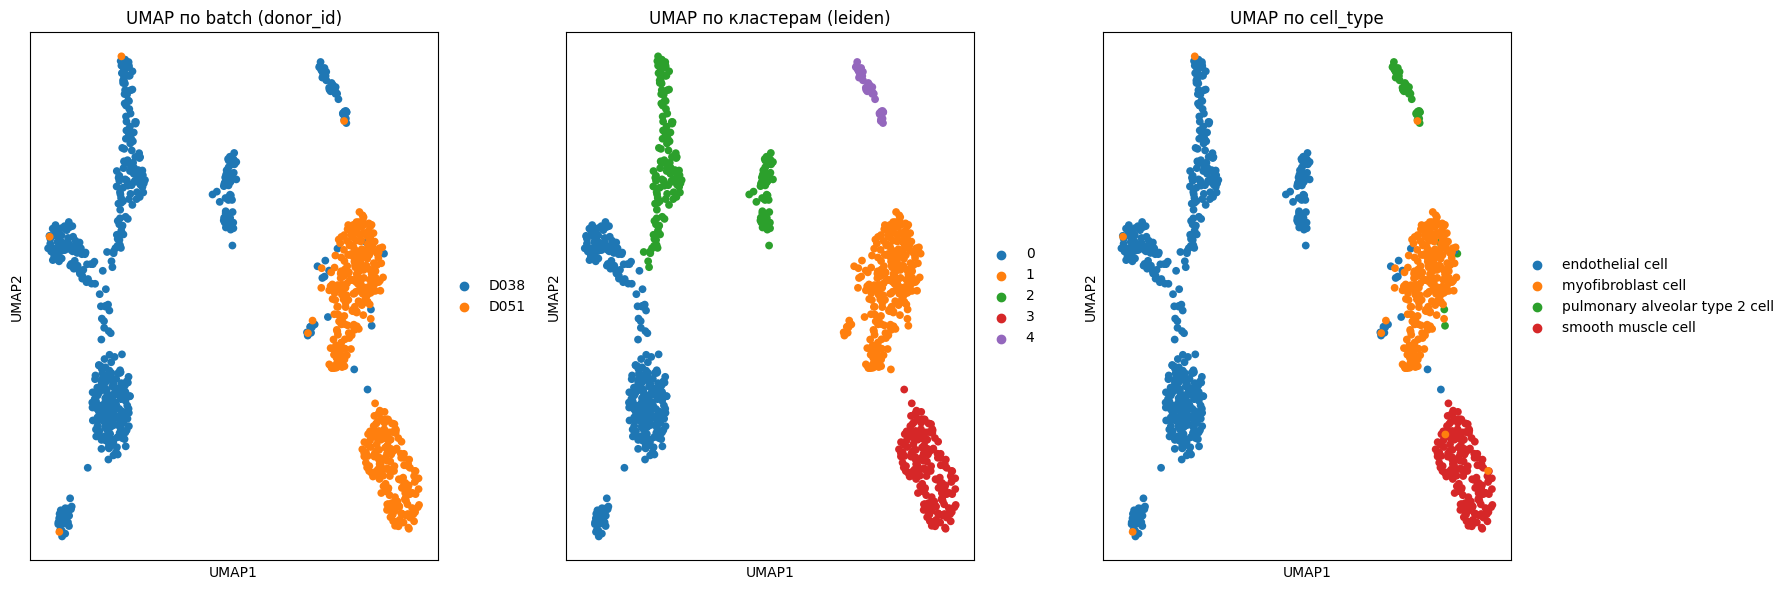

In [29]:
# Harmony
adata_harmony = adata.copy()
sce.pp.harmony_integrate(adata_harmony, key="donor_id", max_iter_harmony=30)
sc.pp.neighbors(adata_harmony, use_rep="X_pca_harmony")
sc.tl.umap(adata_harmony)

# Настраиваем подграфики (subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График с окрашиванием по batch
sc.pl.umap(adata_harmony, color="donor_id", ax=axes[0], show=False)
axes[0].set_title("UMAP по batch (donor_id)")

# Кластеризация и второй график - окрашивание по кластерам (leiden)
sc.tl.leiden(adata_harmony, resolution=0.05)
sc.pl.umap(adata_harmony, color="leiden", ax=axes[1], show=False)
axes[1].set_title("UMAP по кластерам (leiden)")

# График с окрашиванием по cell_type
sc.pl.umap(adata_harmony, color="cell_type", ax=axes[2], show=False)
axes[2].set_title("UMAP по cell_type")

# Отображаем графики
plt.tight_layout()
plt.show()

<ipython-input-30-e3f8a489cabf>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_harmony.obs.groupby(["leiden", "donor_id"]).size().unstack().T


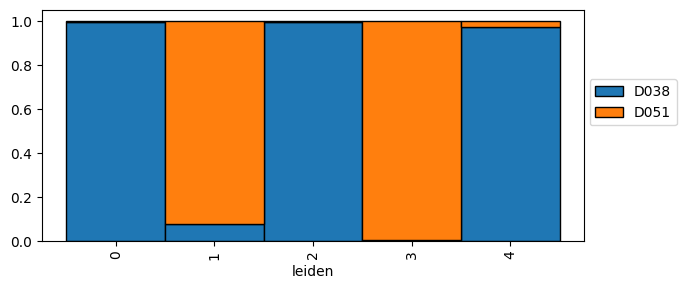

In [30]:
df = adata_harmony.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

In [31]:
#Оценим точность кластеризации при каждом методе батч-коррецкии
import sklearn
from sklearn.metrics import adjusted_rand_score

# Предположим, что adata.obs['cell_type'] содержит известные аннотации
ari_nocorr = adjusted_rand_score(adata_nocorr.obs['cell_type'], adata_nocorr.obs['leiden'])
ari_bbknn = adjusted_rand_score(adata_bbknn.obs['cell_type'], adata_bbknn.obs['leiden'])
ari_harmony = adjusted_rand_score(adata_harmony.obs['cell_type'], adata_harmony.obs['leiden'])


print(f'Adjusted Rand Index (ARI) without batch correction: {ari_nocorr:0.2f}')
print(f'Adjusted Rand Index (ARI) with bbKNN: {ari_bbknn:0.2f}')
print(f'Adjusted Rand Index (ARI) with harmony: {ari_harmony:0.2f}')

Adjusted Rand Index (ARI) without batch correction: 0.99
Adjusted Rand Index (ARI) with bbKNN: 0.59
Adjusted Rand Index (ARI) with harmony: 0.65


Результат harmony похож на результат bbKNN с измененным количесвтом соседей

# Scanorama



In [ ]:
!pip install scanorama

In [33]:
import scanorama

In [39]:
adata_1 = adata[adata.obs['donor_id'] == 'D038']
adata_2 = adata[adata.obs['donor_id'] == 'D051']

In [40]:
#Scanorama
from scanorama import correct_scanpy
# Применяем Scanorama к списку объектов AnnData
adatas = [adata_1, adata_2]
adatas_cor = correct_scanpy(adatas, return_dimred=True)

# Создаем новый объект, содержащий объединенные данные
adata_spatial = sc.concat(adatas_cor, label="library_id", uns_merge="unique")
sc.pp.scale(adata_spatial)

# Соседи с использованием откорректированного представления
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters", n_iterations=2, flavor="igraph", directed=False)


Found 3000 genes among all datasets
[[0.         0.60093897]
 [0.         0.        ]]
Processing datasets (0, 1)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:797: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:797: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


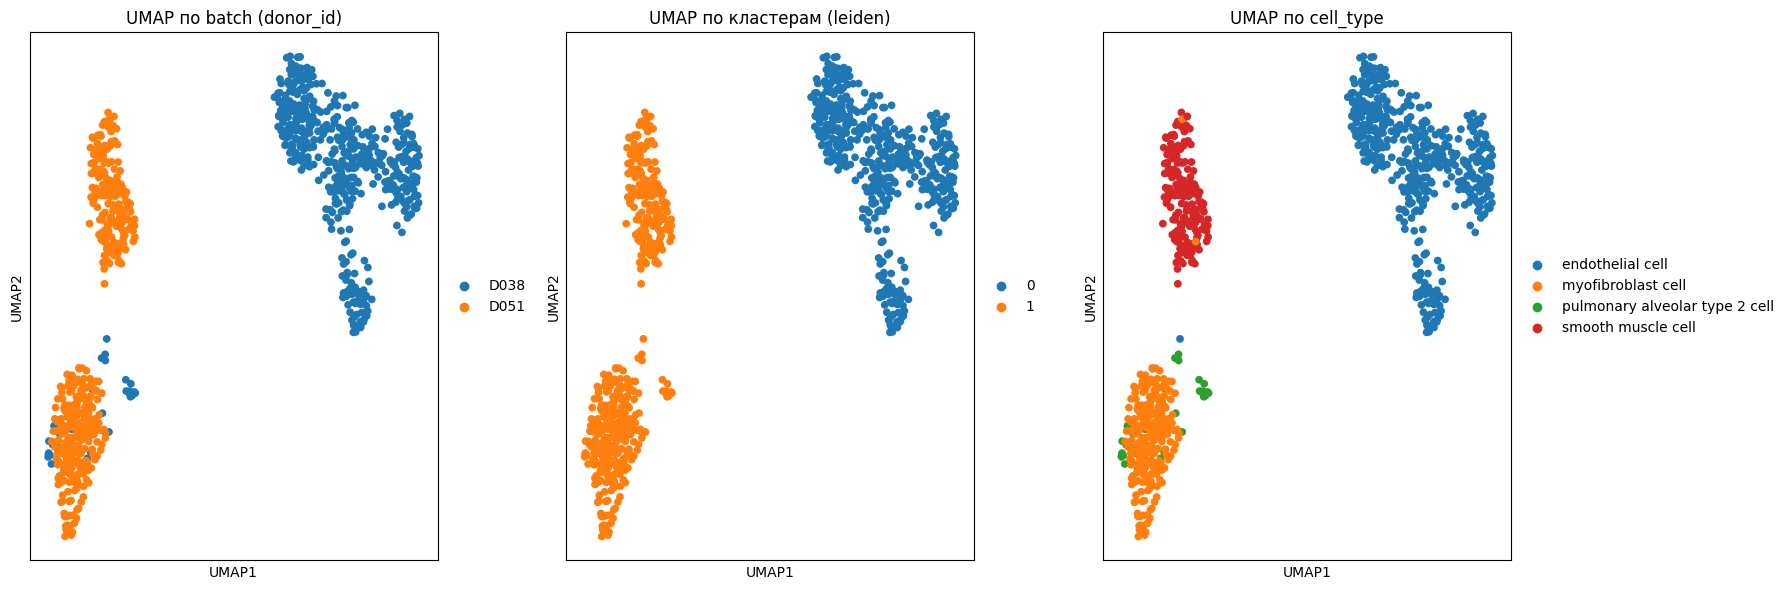

In [42]:
# Настраиваем подграфики (subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График с окрашиванием по batch
sc.pl.umap(adata_spatial, color="donor_id", ax=axes[0], show=False)
axes[0].set_title("UMAP по batch (donor_id)")

# Кластеризация и второй график - окрашивание по кластерам (leiden)
sc.tl.leiden(adata_spatial, resolution=0.05)
sc.pl.umap(adata_spatial, color="leiden", ax=axes[1], show=False)
axes[1].set_title("UMAP по кластерам (leiden)")

# График с окрашиванием по cell_type
sc.pl.umap(adata_spatial, color="cell_type", ax=axes[2], show=False)
axes[2].set_title("UMAP по cell_type")

# Отображаем графики
plt.tight_layout()
plt.show()

In [43]:
#Оценим точность кластеризации при каждом методе батч-коррецкии
import sklearn
from sklearn.metrics import adjusted_rand_score

# Предположим, что adata.obs['cell_type'] содержит известные аннотации
ari_nocorr = adjusted_rand_score(adata_nocorr.obs['cell_type'], adata_nocorr.obs['leiden'])
ari_bbknn = adjusted_rand_score(adata_bbknn.obs['cell_type'], adata_bbknn.obs['leiden'])
ari_harmony = adjusted_rand_score(adata_harmony.obs['cell_type'], adata_harmony.obs['leiden'])
ari_scanorama = adjusted_rand_score(adata_spatial.obs['cell_type'], adata_spatial.obs['leiden'])

print(f'Adjusted Rand Index (ARI) without batch correction: {ari_nocorr:0.2f}')
print(f'Adjusted Rand Index (ARI) without bbKNN: {ari_bbknn:0.2f}')
print(f'Adjusted Rand Index (ARI) with harmony: {ari_harmony:0.2f}')
print(f'Adjusted Rand Index (ARI) with scanorama: {ari_scanorama:0.2f}')

Adjusted Rand Index (ARI) without batch correction: 0.99
Adjusted Rand Index (ARI) without bbKNN: 0.59
Adjusted Rand Index (ARI) with harmony: 0.65
Adjusted Rand Index (ARI) with scanorama: 0.73
